In [5]:
import tensorflow as tf
# from keras.applications import ResNet50, DenseNet121
# from keras.layers import Conv2D, BatchNormalization
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from vbranch.applications.resnet import ResNet50 as vb_ResNet50
from vbranch.applications.densenet import DenseNet121 as vb_DenseNet121
from vbranch.applications.cnn import CNNCifar10
from vbranch.layers import Conv2D, BatchNormalization

Using TensorFlow backend.


In [3]:
with tf.variable_scope('keras_model'):
#     keras_model = ResNet50(weights='imagenet')
    keras_model = DenseNet121(weights='imagenet')

W0727 14:40:14.318435 139860195333888 deprecation_wrapper.py:119] From /home/gong/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 14:40:14.319051 139860195333888 deprecation_wrapper.py:119] From /home/gong/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 14:40:14.323721 139860195333888 deprecation_wrapper.py:119] From /home/gong/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 14:40:14.344909 139860195333888 deprecation_wrapper.py:119] From /home/gong/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session in

In [4]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [3]:
inputs = tf.placeholder('float32', [None, 224, 224, 3])
with tf.variable_scope('vb_model', reuse=tf.AUTO_REUSE):
#     vb_model, assign_ops = vb_ResNet50([inputs]*2, 1000, weights='imagenet', shared_frac=0.5)
    vb_model, assign_ops = vb_DenseNet121([inputs]*2, 1000, weights='imagenet', shared_frac=1)

Instructions for updating:
Colocations handled automatically by placer.
Loading weights for DenseNet121...


In [4]:
vb_model.summary()

i    Layer name                      Output shape          Num param  Inbound               
--------------------------------------------------------------------------------------------
     Input                           [None,224,224,3]                                       
--------------------------------------------------------------------------------------------
     Input                           [None,224,224,3]                                       
--------------------------------------------------------------------------------------------
0    zero_pad (ZeroPadding2D)        [None,230,230,3]      0          input                 
                                     [None,230,230,3]                                       
--------------------------------------------------------------------------------------------
1    conv1/conv (Conv2D)             [None,112,112,64] []  9408       zero_pad              
                                     [None,112,112,64] []             

In [5]:
len(vb_model.layers)

431

## Save Weights

In [5]:
imagenet_weights = {}

for layer in keras_model.layers:
    name = layer.name
    
    if isinstance(layer, Conv2D):
        # Conv
        imagenet_weights[name] = {}
        weights = layer.get_weights()
        assert len(weights) == 1
        f = weights[0]
        assert len(f.shape) == 4
#         b = weights[1]
#         assert len(b.shape) == 1
        imagenet_weights[name] = {'filter' : f} # , 'bias': b}
    elif isinstance(layer, BatchNormalization):
        # Batch norm
        imagenet_weights[name] = {}
        weights = layer.get_weights()
        gamma = weights[0]
        beta = weights[1]
        imagenet_weights[name] = {'scale' : gamma, 'beta':beta}

In [13]:
# with open('weights/densenet121.pickle', 'wb') as pickle_out:
#     pickle.dump( imagenet_weights, pickle_out)

In [3]:
# import pickle
# with open('weights/densenet121.pickle', 'rb') as pickle_in:
#     weights = pickle.load(pickle_in)

## Non-Virtual Branching vs. VB Comparison

In [6]:
# inputs = tf.placeholder('float32', [None, 32, 32, 3])
# with tf.variable_scope('weights_model', reuse=tf.AUTO_REUSE):
#     weights_model = CNNCifar10(inputs, shared_frac=None)

# weights = {}
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     for layer in weights_model.layers:
#         name = layer.name
#         if isinstance(layer, Conv2D):
#             value = layer.get_weights(sess)
#             weights[name] = {'filter':value[0], 'bias':value[1]}
#         elif isinstance(layer, BatchNormalization):
#             value = layer.get_weights(sess)
#             weights[name] = {'scale':value[0], 'beta':value[1]}

In [7]:
# with open('weights/cnn.pickle', 'wb') as pickle_out:
#     pickle.dump(weights, pickle_out)

In [11]:
# with open('weights/cnn.pickle', 'rb') as pickle_in:
#     weights = pickle.load(pickle_in)

In [3]:
inputs = tf.placeholder('float32', [None, 32, 32, 3])
with tf.variable_scope('weights_model', reuse=tf.AUTO_REUSE):
    weights_model, weights_assign = CNNCifar10(inputs, shared_frac=None, weights='weights/cnn.pickle')
with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
    model, assign_ops = CNNCifar10([inputs]*2, shared_frac=1.0, weights='weights/cnn.pickle')

Instructions for updating:
Colocations handled automatically by placer.
Loading weights for CNN...
Loading weights for CNN...


In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([weights_assign, assign_ops])
    outputs = sess.run([weights_model.layers[20].output, list(model.layers[20].output)[0][0]], 
                       feed_dict={inputs:np.random.randn(1, 32, 32,3)*10})

In [23]:
outputs[0]

array([[0.40565485, 0.38548923, 0.41206118, 0.39657468, 0.4028846 ,
        0.3812822 , 0.41114193, 0.40573865, 0.38767347, 0.42563885,
        0.396288  , 0.3864969 , 0.3932613 , 0.4056904 , 0.4019727 ,
        0.40359625, 0.4060644 , 0.39249778, 0.41199112, 0.40035555,
        0.4102739 , 0.38651523, 0.39037764, 0.4004621 , 0.39654514,
        0.3988871 , 0.4024982 , 0.4213677 , 0.4019068 , 0.41693556,
        0.41043198, 0.3902299 , 0.38609624, 0.38790268, 0.42038462,
        0.4152601 , 0.38852024, 0.3933639 , 0.3980134 , 0.40156356,
        0.40439802, 0.39582056, 0.40095595, 0.40093195, 0.42236996,
        0.42991468, 0.40453842, 0.38113004, 0.4036399 , 0.41610533,
        0.3901181 , 0.38458824, 0.41071257, 0.39555034, 0.3855037 ,
        0.40227863, 0.4037717 , 0.38212818, 0.41129568, 0.41086847,
        0.40459564, 0.39518622, 0.39550573, 0.41960782, 0.34941217,
        0.40911394, 0.3848059 , 0.39794636, 0.42080307, 0.38992518,
        0.41707945, 0.405694  , 0.39935976, 0.41

In [21]:
outputs[1]

array([[0.40565485, 0.38548923, 0.41206118, 0.39657468, 0.4028846 ,
        0.3812822 , 0.41114193, 0.40573865, 0.38767347, 0.42563885,
        0.396288  , 0.3864969 , 0.3932613 , 0.4056904 , 0.4019727 ,
        0.40359625, 0.4060644 , 0.39249778, 0.41199112, 0.40035555,
        0.4102739 , 0.38651523, 0.39037764, 0.4004621 , 0.39654514,
        0.3988871 , 0.4024982 , 0.4213677 , 0.4019068 , 0.41693556,
        0.41043198, 0.3902299 , 0.38609624, 0.38790268, 0.42038462,
        0.4152601 , 0.38852024, 0.3933639 , 0.3980134 , 0.40156356,
        0.40439802, 0.39582056, 0.40095595, 0.40093195, 0.42236996,
        0.42991468, 0.40453842, 0.38113004, 0.4036399 , 0.41610533,
        0.3901181 , 0.38458824, 0.41071257, 0.39555034, 0.3855037 ,
        0.40227863, 0.4037717 , 0.38212818, 0.41129568, 0.41086847,
        0.40459564, 0.39518622, 0.39550573, 0.41960782, 0.34941217,
        0.40911394, 0.3848059 , 0.39794636, 0.42080307, 0.38992518,
        0.41707945, 0.405694  , 0.39935976, 0.41

In [18]:
model.layers[20].output

[[<tf.Tensor 'model/global_avg_pool2d/global_avg_pool2d/output:0' shape=(?, 128) dtype=float32>, <vbranch.utils.layer.EmptyOutput object at 0x7fe0b7abd6d8>], [<tf.Tensor 'model/global_avg_pool2d/global_avg_pool2d_1/output:0' shape=(?, 128) dtype=float32>, <vbranch.utils.layer.EmptyOutput object at 0x7fe0b7abd748>]]

In [2]:
var = tf.get_variable('var', shape=[3,3,32,64])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    value = sess.run(var)

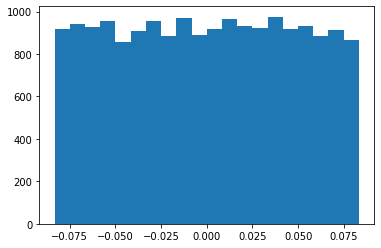

In [12]:
plt.hist(value.flatten(), bins=20)
plt.show()

In [13]:
value.min(), value.max()

(-0.08331917, 0.08326963)

In [8]:
np.sqrt(6/(96))

0.25

In [9]:
0.25/value.min()

-3.000178019834682

In [10]:
0.25/3

0.08333333333333333